In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
eigenvalues = np.load('rawData/data_1_1.npy')
kPoints = np.load('rawData/points_1_1.npy')

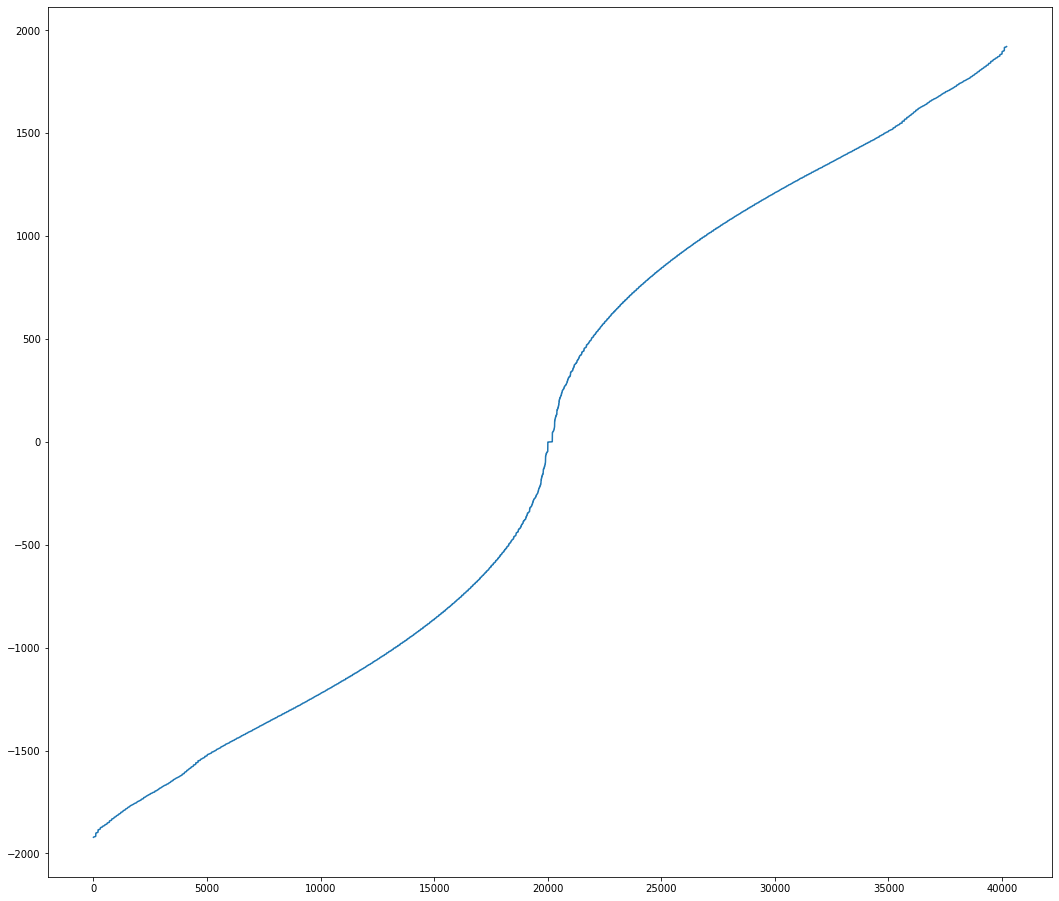

In [25]:
fig = plt.figure(figsize=(18,16))
plt.plot(np.sort(eigenvalues))

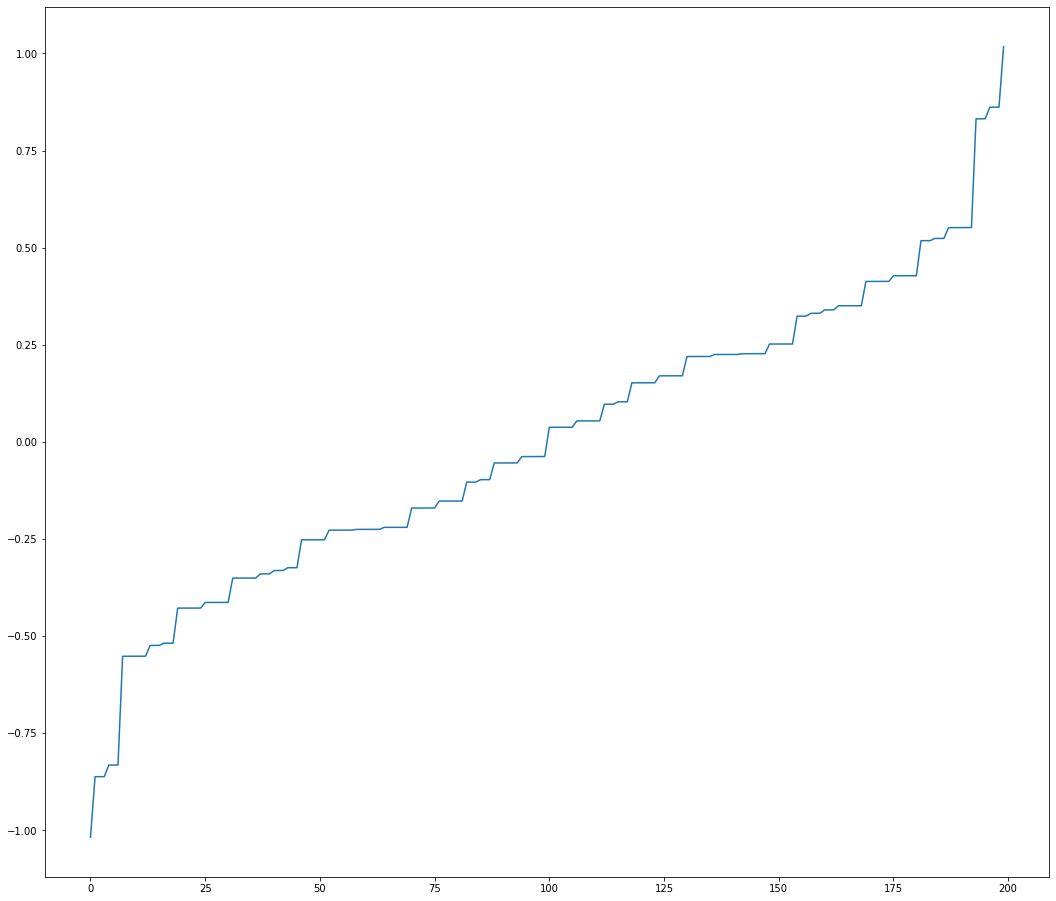

In [26]:
cutoff = 10
fig = plt.figure(figsize=(18,16))
plt.plot(np.sort([i for i in eigenvalues if abs(i) < cutoff]))